In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import open3d as o3d 
from mpl_toolkits import mplot3d

from sklearn.neighbors import KDTree 



In [2]:
imgL = cv.imread('images/leftStereo.jpg') # downscale images for faster processing
imgR = cv.imread('images/rightStereo.jpg')
gray= cv.cvtColor(imgL,cv.COLOR_BGR2GRAY)


In [3]:
stereo = cv.StereoBM_create(numDisparities=16, blockSize=15)
frame0_new = cv.cvtColor(imgL, cv.COLOR_BGR2GRAY)
frame1_new = cv.cvtColor(imgR, cv.COLOR_BGR2GRAY)

disp = stereo.compute(frame0_new,frame1_new)
h, w = imgL.shape[:2]
f = 0.8*w                          # guess for focal length


In [4]:
sift = cv.xfeatures2d.SIFT_create()


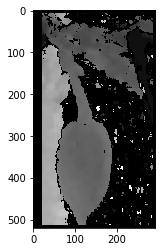

In [5]:
kp = sift.detect(gray,None)
img=cv.drawKeypoints(gray,kp,imgL)
plt.imshow(disp, 'gray');
plt.show()

In [6]:
h, w = disp.shape
Q = np.float32([[1, 0,  0, w / 2],
                [0, -1,  0,  h / 2],  # turn points 180 deg around x-axis,
                [0, 0, f,  0],  # so that y-axis looks up
                [0, 0,  0,  1]])

real_points = cv.reprojectImageTo3D(disp, Q)
mask = disp > disp.min()
points = real_points[mask]

In [7]:

y_tree = KDTree(points)
y_index_of_closest = y_tree.query(points, k = 1, return_distance = False)

In [14]:
y_index_of_closest[0,0]

0

In [ ]:
pts = [k.pt for k in kp]
realWorldSift = [[],[],[]]
for point in range(len(pts)):
    y = int(pts[point][0])
    x = int(pts[point][1])
    Z = disp[x,y]
            
    realWorldSift[0].append(x * Z / f)
    realWorldSift[1].append(y * Z / f)
    realWorldSift[2].append(Z)

    

In [ ]:
real_X = np.zeros(disp.shape)
real_Y = np.zeros(disp.shape)
for x in range(len(disp[0])):
    for y in range(len(disp[1])):
        real_X[x,y] = x * disp[x,y] / f
        real_Y[x,y] = y * disp[x,y] / f

        
        

In [ ]:
globalCoords = np.zeros([disp.shape[0] * disp.shape[1], 3])

for x in range(len(disp[0])):
    for y in range(len(disp[1])):
        globalCoords[x*y, 0] = x * disp[x,y] / f
        globalCoords[x*y, 1] = y * disp[x,y] / f
        globalCoords[x*y, 2] = disp[x,y]

In [ ]:
plt.scatter(x=real_X, 
            y=real_Y, 
            )
plt.title('Global Pointcloud')
plt.show(block=False)
    

In [ ]:
plt.scatter(x=globalCoords[:,0], 
            y=globalCoords[:,1], 
            )
plt.title('Global Pointcloud')
plt.show(block=False)